<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-мультиколлинеарность" data-toc-modified-id="Проверка-на-мультиколлинеарность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка на мультиколлинеарность</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ridge Regression</a></span></li><li><span><a href="#Lightgbm-(Decision-Tree-Regressor)" data-toc-modified-id="Lightgbm-(Decision-Tree-Regressor)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lightgbm (Decision Tree Regressor)</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Ridge-Regression-test" data-toc-modified-id="Ridge-Regression-test-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ridge Regression test</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Оп проекте:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    GridSearchCV, 
    TimeSeriesSplit,
    train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

## Подготовка

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col = 0, parse_dates=[0])

In [5]:
data.sort_index(inplace=True)

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
print(data.idxmin())
data.idxmax()

num_orders   2018-03-01 05:20:00
dtype: datetime64[ns]


num_orders   2018-08-13 02:20:00
dtype: datetime64[ns]

Мы имеем данные за период с 1 марта 2018 до 13 августа 2018. Данные имеют интервал добавления в 10 минут.

Мы будем прогнозировать заказ на следующий час, поэтому данные необходимо ресемплировать на почасовые 

In [8]:
data = data.resample('1H').sum()

In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [11]:
data.shape

(4416, 1)

## Анализ

In [12]:
data.idxmin()

num_orders   2018-04-06 06:00:00
dtype: datetime64[ns]

In [13]:
data.idxmax()

num_orders   2018-08-20 02:00:00
dtype: datetime64[ns]

In [14]:
decomposed = seasonal_decompose(data)

<Axes: xlabel='datetime'>

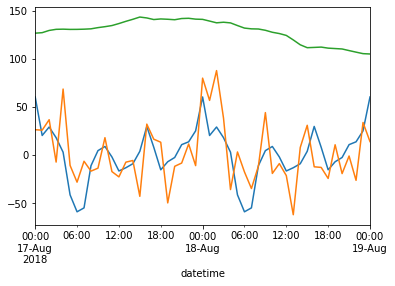

In [15]:
#посмотрим на декомпозированные данные в течение 2 суток 
#возьмем предпоследний день из доступных в данных
decomposed.seasonal['2018-08-17 00:00:00':'2018-08-19 00:00:00'].plot()
decomposed.resid['2018-08-17 00:00:00':'2018-08-19 00:00:00'].plot()
decomposed.trend['2018-08-17 00:00:00':'2018-08-19 00:00:00'].plot()

<Axes: xlabel='datetime'>

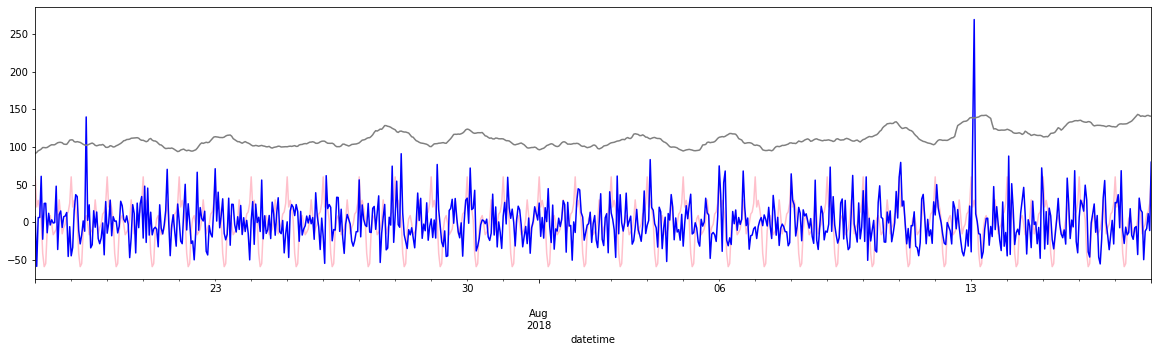

In [16]:
#посмотрим на декомпозированные данные в течение месяца 
#возьмем предпоследний месяц из доступных в данных
plt.figure(figsize = (20,5))
decomposed.seasonal['2018-07-18 00:00:00':'2018-08-18 00:00:00'].plot(color = 'pink')
decomposed.resid['2018-07-18 00:00:00':'2018-08-18 00:00:00'].plot(color = 'blue')
decomposed.trend['2018-07-18 00:00:00':'2018-08-18 00:00:00'].plot(color = 'grey')

Наблюдается ежедневная сезонность

Видим, что почасовая сезонность отсутствует, есть возрастающий тренд и нестационарные остатки

In [17]:
#добавим в таблицу новые признаки
#напишем для этого функцию
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Посмотрев на распределение заказов одного дня, попробуем сглаживание (rolling_mean) в 6 часов как среднее между минимальным и максимальным значением заказов в течение дня

Лаги зададим на 24 часа из допущения, что количество закзов в предыдущие 24 часа может быть важно для прогназирования

In [18]:
make_features(data,24,6)
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='num_orders', ylabel='Count'>

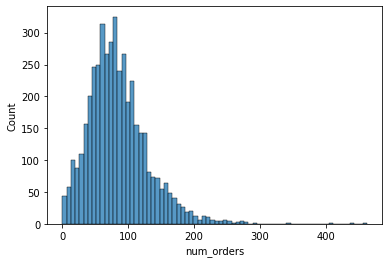

In [19]:
#распределение зависимой переменной
sns.histplot(data['num_orders'])

In [20]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

<Axes: xlabel='datetime'>

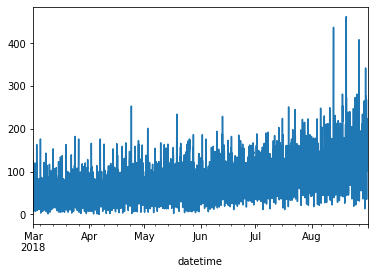

In [21]:
#распределение количества заказов по времени
data['num_orders'].plot()

<Axes: xlabel='datetime'>

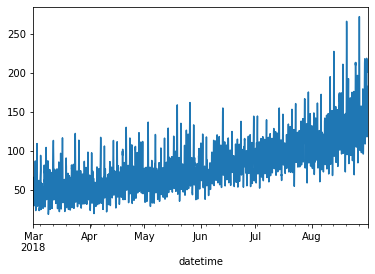

In [22]:
#сглаженное распределение количества заказов
data['rolling_mean'].plot()

In [23]:
data.describe()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,...,4400.000000,4399.000000,4398.000000,4397.000000,4396.000000,4395.000000,4394.000000,4393.000000,4392.000000,4410.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,...,84.095227,84.103887,84.115052,84.116443,84.074613,84.071217,84.038006,84.012975,83.969262,84.338473
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,...,44.733738,44.735135,44.734091,44.739084,44.658098,44.662612,44.613388,44.587597,44.498432,32.925423
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.500000
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,61.875000
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.000000
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,102.166667
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,272.333333


Переменный имеют различный масштаб, для первичного моделирования мы не будем применять масштабирование переменных, однако потенциально можем изменить масштаб для будущих моделей

### Проверка на мультиколлинеарность

In [24]:
data.corr()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
num_orders,1.000000,-1.962844e-02,4.292046e-03,0.624138,0.465444,0.321173,0.248791,0.230489,0.238449,0.291733,...,0.273940,0.257664,0.212274,0.198663,0.219707,0.267113,0.406759,0.556994,0.691576,0.484648
dayofweek,-0.019628,1.000000e+00,2.160411e-18,-0.027331,-0.029567,-0.029056,-0.028695,-0.028752,-0.026911,-0.026913,...,-0.005003,-0.002608,-0.000616,-0.001592,0.000121,0.000522,0.011789,0.021074,0.030720,-0.038755
hour,0.004292,2.160411e-18,1.000000e+00,-0.076112,-0.120424,-0.154777,-0.146248,-0.123327,-0.074180,-0.100352,...,-0.080903,0.096427,0.287042,0.421498,0.414856,0.356750,0.264147,0.199136,0.004107,-0.158072
lag_1,0.624138,-2.733141e-02,-7.611189e-02,1.000000,0.623446,0.464959,0.320580,0.248332,0.229212,0.237082,...,0.236406,0.274704,0.258578,0.212530,0.196700,0.219685,0.265663,0.405869,0.555999,0.657145
lag_2,0.465444,-2.956675e-02,-1.204245e-01,0.623446,1.000000,0.623151,0.464503,0.320169,0.246899,0.227617,...,0.257357,0.237277,0.275808,0.258953,0.210283,0.196681,0.217897,0.264405,0.404142,0.746109
lag_3,0.321173,-2.905576e-02,-1.547765e-01,0.464959,0.623151,1.000000,0.622932,0.464285,0.319511,0.246106,...,0.311007,0.257780,0.237798,0.275946,0.257980,0.210226,0.195747,0.217185,0.263419,0.795296
lag_4,0.248791,-2.869538e-02,-1.462479e-01,0.320580,0.464503,0.622932,1.000000,0.622791,0.463843,0.318875,...,0.329509,0.311417,0.258272,0.237911,0.275103,0.257936,0.209387,0.195068,0.216184,0.795138
lag_5,0.230489,-2.875218e-02,-1.233272e-01,0.248332,0.320169,0.464285,0.622791,1.000000,0.622699,0.463602,...,0.315145,0.329808,0.311793,0.258347,0.237330,0.275061,0.257434,0.208919,0.194383,0.745848
lag_6,0.238449,-2.691094e-02,-7.417954e-02,0.229212,0.246899,0.319511,0.463843,0.622699,1.000000,0.622010,...,0.259809,0.315967,0.330815,0.312143,0.256506,0.237327,0.273596,0.256298,0.206857,0.655536
lag_7,0.291733,-2.691297e-02,-1.003519e-01,0.237082,0.227617,0.246106,0.318875,0.463602,0.622010,1.000000,...,0.265927,0.260662,0.317063,0.331236,0.310285,0.256539,0.235651,0.272398,0.254192,0.481147


Видим, что в нашем наборе данных есть высоко скоррелированные независимые перменные, например, лаги и rolling_mean сильно коррелируют друг с другом (R-Пирсона около 0.8). Мы не будем их убирать, применим Ridge Regression, которая учитывает мультиколлинеарность

In [25]:
#удалим пропуски
data.isna().sum()

num_orders       0
dayofweek        0
hour             0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
rolling_mean     6
dtype: int64

In [26]:
data = data.dropna()

## Обучение моделей

In [27]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=12345, shuffle = False
)

In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3952, 27) (440, 27) (3952,) (440,)


### Ridge Regression

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

In [30]:
model_ridge = Ridge(random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    cv = tscv,
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best_score RMSE: {gs_ridge.best_score_*(-1)}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_score RMSE: 27.13835792299567
best_params: {'alpha': 0.2}


### Lightgbm (Decision Tree Regressor)

In [31]:
param_grid = {'learning_rate': [0.05,0.08],
              'n_estimators': [500,1000],
              'max_depth': [5, 10]}

In [32]:
estimator = LGBMRegressor(objective='regression', random_state=12345)

In [33]:
%%time
lgbm = GridSearchCV(estimator=estimator, 
                     param_grid=param_grid,
                     cv=tscv,
                     n_jobs=-1, 
                     scoring='neg_root_mean_squared_error')
lgbm.fit(X_train, y_train)
# лучшее значение RMSE на кросс-валидации
print(f'best_score RMSE: {lgbm.best_score_*(-1)}')
# лучшие гиперпараметры
print(f'best_params: {lgbm.best_params_}')

best_score RMSE: 24.681412278762586
best_params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}
CPU times: user 1.47 s, sys: 60.9 ms, total: 1.53 s
Wall time: 23.1 s


## Тестирование

### Ridge Regression test

In [36]:
pred_ridge = gs_ridge.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_ridge))

45.22409410120272

LGBMRegression test

In [37]:
pred_lgbm = lgbm.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_lgbm))

40.363100413911205

## Выводы


*   Были построены две модели с кросс-валидацией и перебором гиперпараметров для поиска наиболее удачных. Построенные модели Ridge Regression и LightGBM Regression. RMSE на обучающей выборке 27.1 и 24.7 соответствено. RMSE на тестовой выборке 45.2 и 40.4 соответственно.
*   Таким образом, лучшая модель
LightGBM Regression. Эта модель ошибается в среднем на 40.4 для прогнозирования заказов в следующем часу.